# Test Environment
Need to ensure that control steps in data is the same as control steps in training

In [6]:
import sys
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline
main_path = Path().resolve().parent
if str(main_path) not in sys.path:
    sys.path.append(str(main_path))

import os

os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.95"
os.environ["MUJOCO_GL"] = "glfw"
os.environ["XLA_FLAGS"] = (
    "--xla_gpu_enable_triton_softmax_fusion=true --xla_gpu_triton_gemm_any=True "
)
os.environ["PYOPENGL_PLATFORM"] = "glfw"

from absl import flags
import hydra
from omegaconf import DictConfig, OmegaConf
import uuid

from pathlib import Path

import functools
import jax
from typing import Dict
import wandb
import imageio
from brax import envs
from dm_control import mjcf as mjcf_dm
from dm_control.locomotion.walkers import rescale

import track_mjx.agent.ppo as ppo
from track_mjx.agent import ppo
from brax.io import model
import numpy as np
import pickle
import warnings
from jax import numpy as jp

from track_mjx.environment.task.multi_clip_tracking import MultiClipTracking
from track_mjx.environment.task.single_clip_tracking import SingleClipTracking
# from track_mjx.io.preprocess.mjx_preprocess import process_clip_to_train
# from track_mjx.io import preprocess as preprocessing  # the pickle file needs it
from track_mjx.environment import wrappers
from track_mjx.io import load
from track_mjx.environment.walker.rodent import Rodent
from track_mjx.environment.walker.fly import Fly

from track_mjx.environment.task.reward import RewardConfig

FLAGS = flags.FLAGS
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [8]:
import yaml

main_dir = Path().resolve().parent
print(main_dir)
if str(main_dir) not in sys.path:
    sys.path.append(str(main_dir))
    
config_path = "track_mjx/config"
data_path = "/allen/aind/scratch/tim.kim/track-mjx/data/transform_snips.h5"
cfg = load.load_configs(main_dir / config_path, "rodent-full-clips.yaml")

env_args = cfg["env_config"]["env_args"]
env_rewards = cfg["env_config"]["reward_weights"]
# train_cfg = cfg["train_setup"]["train_config"]
walker_cfg = cfg["walker_config"]
# traj_cfg = cfg["reference_config"]
walker_type = cfg["walker_type"]
traj_config = cfg["reference_config"]
try:
    n_devices = jax.device_count(backend="gpu")
    print(f"Using {n_devices} GPUs")
except:
    n_devices = 1
    print("Not using GPUs")

envs.register_environment("rodent_single_clip", SingleClipTracking)
envs.register_environment("rodent_multi_clip", MultiClipTracking)
envs.register_environment("fly_multi_clip", MultiClipTracking)

reference_clip = load.make_multiclip_data(data_path)

walker_map = {
    "rodent": Rodent,
    "fly": Fly,
}
walker_class = walker_map[walker_type]
walker = walker_class(**walker_cfg)

reward_config = RewardConfig(
    too_far_dist = env_rewards["too_far_dist"],
    bad_pose_dist = env_rewards["bad_pose_dist"],
    bad_quat_dist = env_rewards["bad_quat_dist"],
    ctrl_cost_weight = env_rewards["ctrl_cost_weight"],
    ctrl_diff_cost_weight = env_rewards["ctrl_diff_cost_weight"],
    pos_reward_weight = env_rewards["pos_reward_weight"],
    quat_reward_weight = env_rewards["quat_reward_weight"],
    joint_reward_weight = env_rewards["joint_reward_weight"],
    angvel_reward_weight = env_rewards["angvel_reward_weight"],
    bodypos_reward_weight = env_rewards["bodypos_reward_weight"],
    endeff_reward_weight = env_rewards["endeff_reward_weight"],
    healthy_z_range = env_rewards["healthy_z_range"],
    pos_reward_exp_scale = env_rewards["pos_reward_exp_scale"],
    quat_reward_exp_scale = env_rewards["quat_reward_exp_scale"],
    joint_reward_exp_scale = env_rewards["joint_reward_exp_scale"],
    angvel_reward_exp_scale = env_rewards["angvel_reward_exp_scale"],
    bodypos_reward_exp_scale = env_rewards["bodypos_reward_exp_scale"],
    endeff_reward_exp_scale = env_rewards["endeff_reward_exp_scale"],
    penalty_pos_distance_scale = jp.array(env_rewards["penalty_pos_distance_scale"]),
)

env = envs.get_environment(
    env_name=cfg["env_config"]["env_name"],
    reference_clip=reference_clip,
    walker=walker,
    reward_config=reward_config,
    **env_args,
    **traj_config,
)

print("Environment created successfully!")

/home/tim.kim/track-mjx
Using 2 GPUs
env._steps_for_cur_frame: 2.0
Environment created successfully!


In [9]:
rollout_env = wrappers.AutoResetWrapperTracking(
    wrappers.RenderRolloutWrapperTracking(env)
    )
jit_reset = jax.jit(rollout_env.reset)
jit_step = jax.jit(rollout_env.step)
key = jax.random.PRNGKey(0)

In [10]:
_, key = jax.random.split(key)
state = jit_reset(key)

In [11]:
rollout = [state]
frames = [env._get_cur_frame(state.info, state.pipeline_state)]
for i in range(1000):
    _, key = jax.random.split(key)
    action = jax.random.normal(key, shape=(env.action_size,))
    state = jit_step(state, action)
    rollout.append(state)
    frames.append(env._get_cur_frame(state.info, state.pipeline_state))

In [12]:
fall_metrics = np.array([s.metrics["fall"] for s in rollout])
too_far_metrics = np.array([s.metrics["too_far"] for s in rollout])
bad_pose_metrics = np.array([s.metrics["bad_pose"] for s in rollout])
bad_quat_metrics = np.array([s.metrics["bad_quat"] for s in rollout])
nan_metrics = np.array([s.metrics["nan"] for s in rollout])

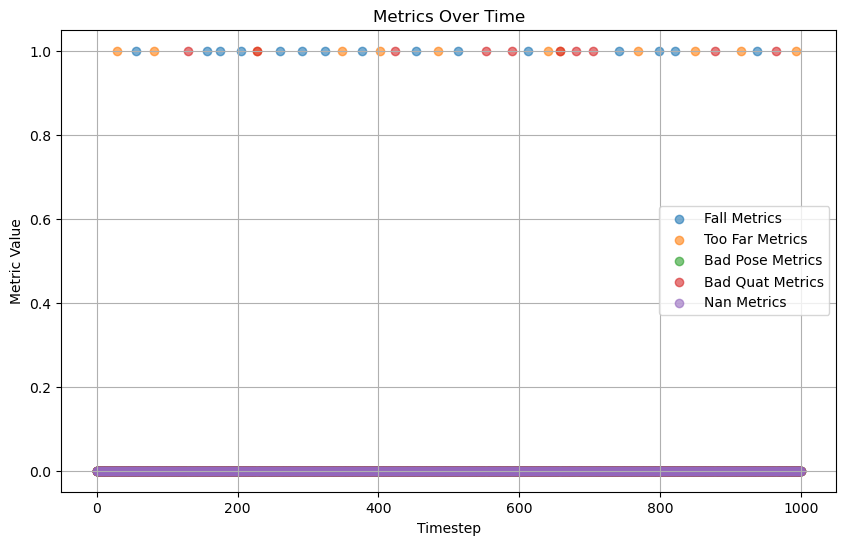

In [13]:
# Plotting the metrics as scatter plots
plt.figure(figsize=(10, 6))

timesteps = range(len(rollout))

plt.scatter(timesteps, fall_metrics, label="Fall Metrics", alpha=0.6)
plt.scatter(timesteps, too_far_metrics, label="Too Far Metrics", alpha=0.6)
plt.scatter(timesteps, bad_pose_metrics, label="Bad Pose Metrics", alpha=0.6)
plt.scatter(timesteps, bad_quat_metrics, label="Bad Quat Metrics", alpha=0.6)
plt.scatter(timesteps, nan_metrics, label="Nan Metrics", alpha=0.6)

plt.xlabel("Timestep")
plt.ylabel("Metric Value")
plt.title("Metrics Over Time")
plt.legend()
plt.grid(True)

plt.show()

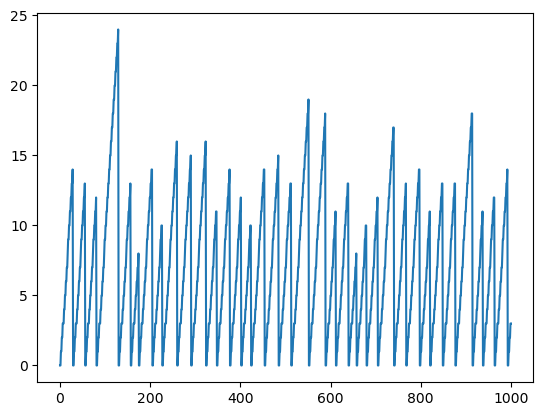

In [14]:
plt.plot(np.arange(len(frames)), frames)

In [15]:
overlap = (fall_metrics + 
           too_far_metrics + 
           bad_pose_metrics + 
           bad_quat_metrics + 
           nan_metrics)
print(overlap.shape)
np.count_nonzero(np.array(overlap)>=1)

(1001,)


35

In [16]:
np.count_nonzero(np.array(frames)==0)

72

In [18]:
state = env.reset(key)
state.pipeline_state.qpos[:3]

Array([-0.12038879, -0.04180336,  0.06364212], dtype=float32)

In [20]:
state.info

{'clip_idx': Array(784, dtype=int32),
 'start_frame': Array(19, dtype=int32),
 'prev_ctrl': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.], dtype=float32),
 'reference_obs_size': 470}

In [21]:
reference_clip = jax.tree_map(
            lambda x: x[state.info["start_frame"]], env._get_reference_clip(state.info)
        )
reference_clip.position

Array([-0.11947972, -0.04204313,  0.06447853], dtype=float32)